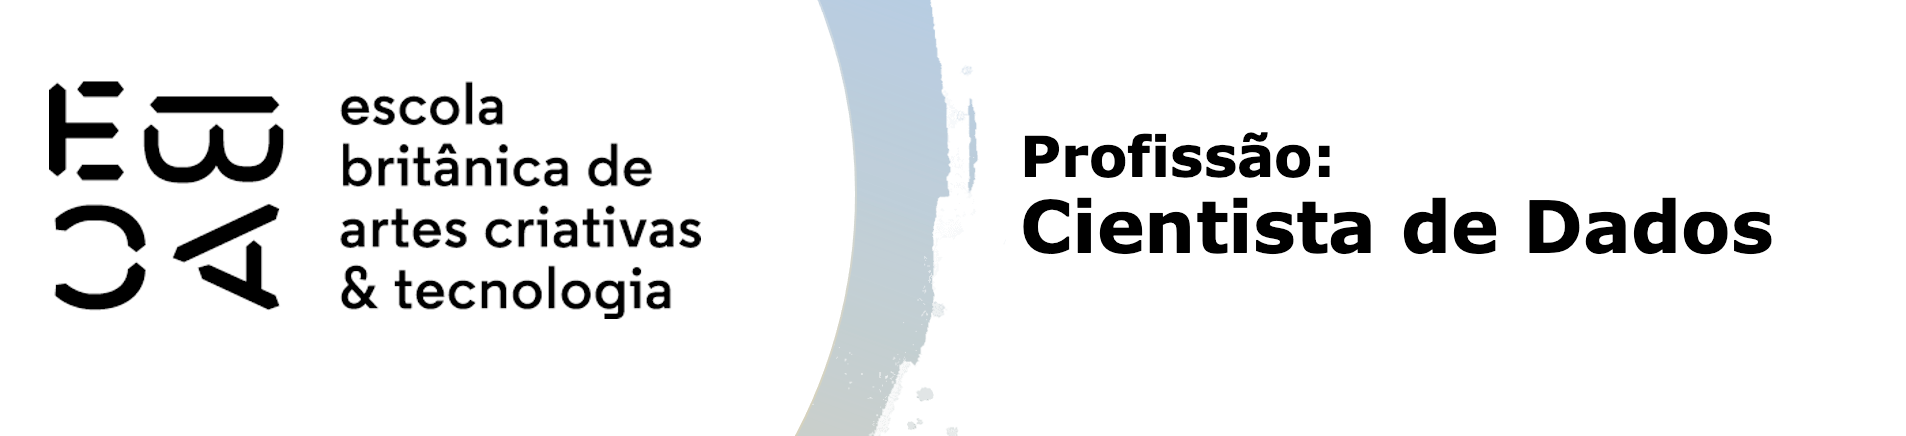

# Tarefa - Agrupamento hierárquico

Neste exercício vamos usar a base [online shoppers purchase intention](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset) de Sakar, C.O., Polat, S.O., Katircioglu, M. et al. Neural Comput & Applic (2018). [Web Link](https://doi.org/10.1007/s00521-018-3523-0).

A base trata de registros de 12.330 sessões de acesso a páginas, cada sessão sendo de um único usuário em um período de 12 meses, para posteriormente estudarmos a relação entre o design da página e o perfil do cliente - "Será que clientes com comportamento de navegação diferentes possuem propensão a compra diferente?" 

Nosso objetivo agora é agrupar as sessões de acesso ao portal considerando o comportamento de acesso e informações da data, como a proximidade a uma data especial, fim de semana e o mês.

|Variavel                |Descrição          | 
|------------------------|:-------------------| 
|Administrative          | Quantidade de acessos em páginas administrativas| 
|Administrative_Duration | Tempo de acesso em páginas administrativas | 
|Informational           | Quantidade de acessos em páginas informativas  | 
|Informational_Duration  | Tempo de acesso em páginas informativas  | 
|ProductRelated          | Quantidade de acessos em páginas de produtos | 
|ProductRelated_Duration | Tempo de acesso em páginas de produtos | 
|BounceRates             | *Percentual de visitantes que entram no site e saem sem acionar outros *requests* durante a sessão  | 
|ExitRates               | * Soma de vezes que a página é visualizada por último em uma sessão dividido pelo total de visualizações | 
|PageValues              | * Representa o valor médio de uma página da Web que um usuário visitou antes de concluir uma transação de comércio eletrônico | 
|SpecialDay              | Indica a proximidade a uma data festiva (dia das mães etc) | 
|Month                   | Mês  | 
|OperatingSystems        | Sistema operacional do visitante | 
|Browser                 | Browser do visitante | 
|Region                  | Região | 
|TrafficType             | Tipo de tráfego                  | 
|VisitorType             | Tipo de visitante: novo ou recorrente | 
|Weekend                 | Indica final de semana | 
|Revenue                 | Indica se houve compra ou não |

\* variávels calculadas pelo google analytics

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import scipy.cluster.hierarchy as shc

from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage

In [13]:
df = pd.read_csv('online_shoppers_intention.csv')

In [14]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [15]:
df.Revenue.value_counts(dropna=False)

Revenue
False    10422
True      1908
Name: count, dtype: int64

## Análise descritiva

Faça uma análise descritiva das variáveis do escopo.

- Verifique a distribuição dessas variáveis
- Veja se há valores *missing* e caso haja, decida o que fazer
- Faça mais algum tratamento nas variáveis caso ache pertinente

In [16]:
print(df.isna().sum())

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64


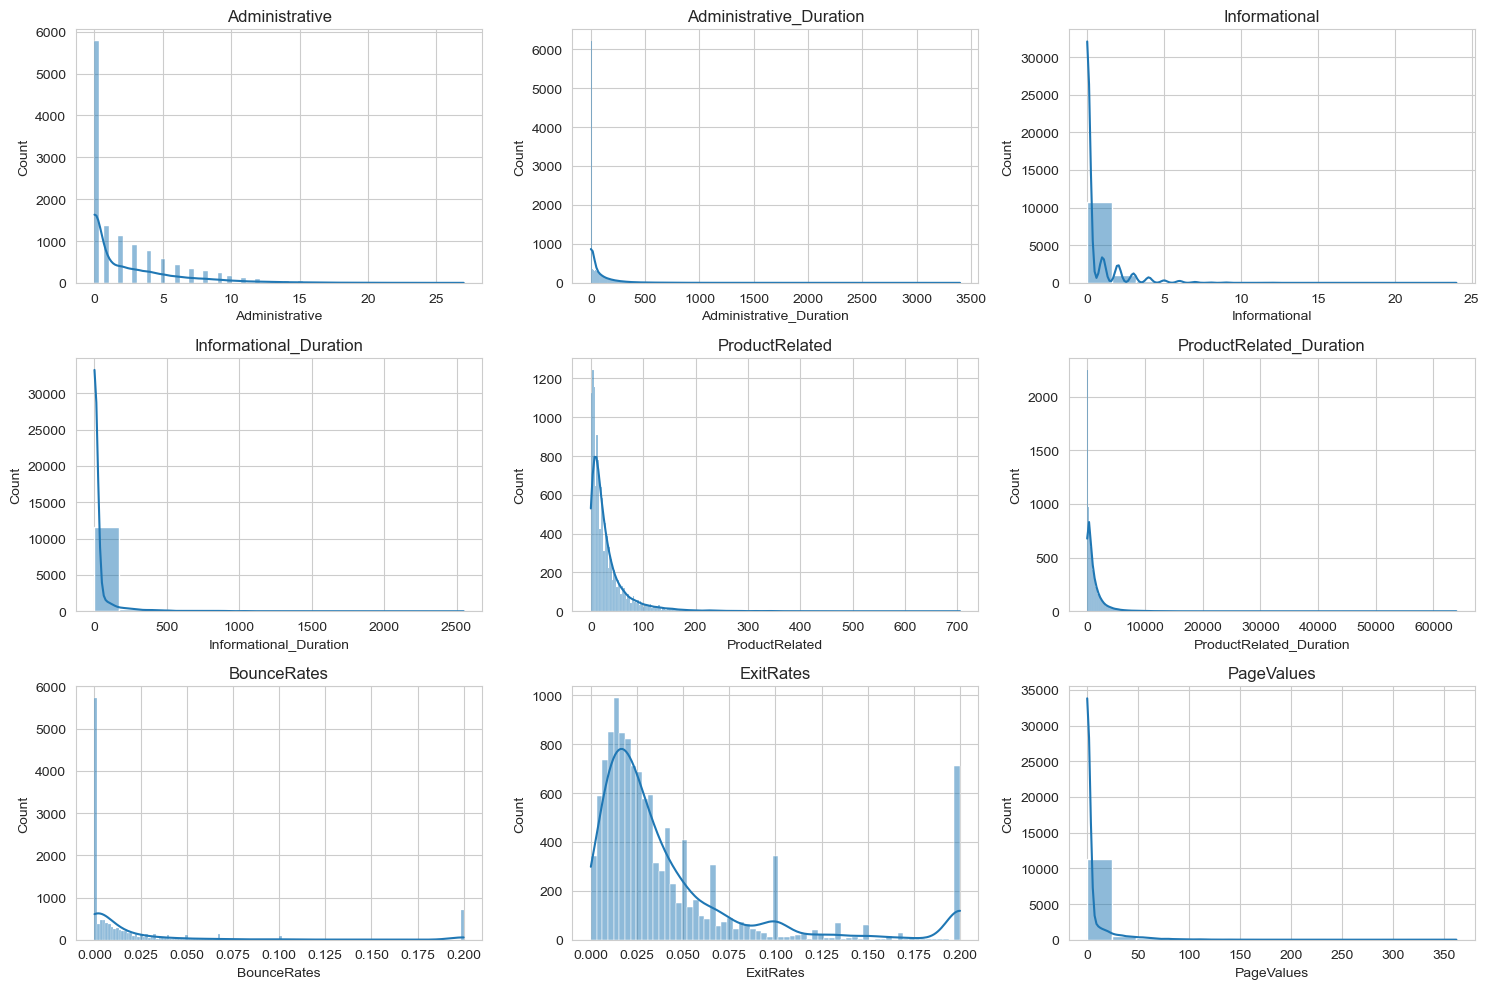

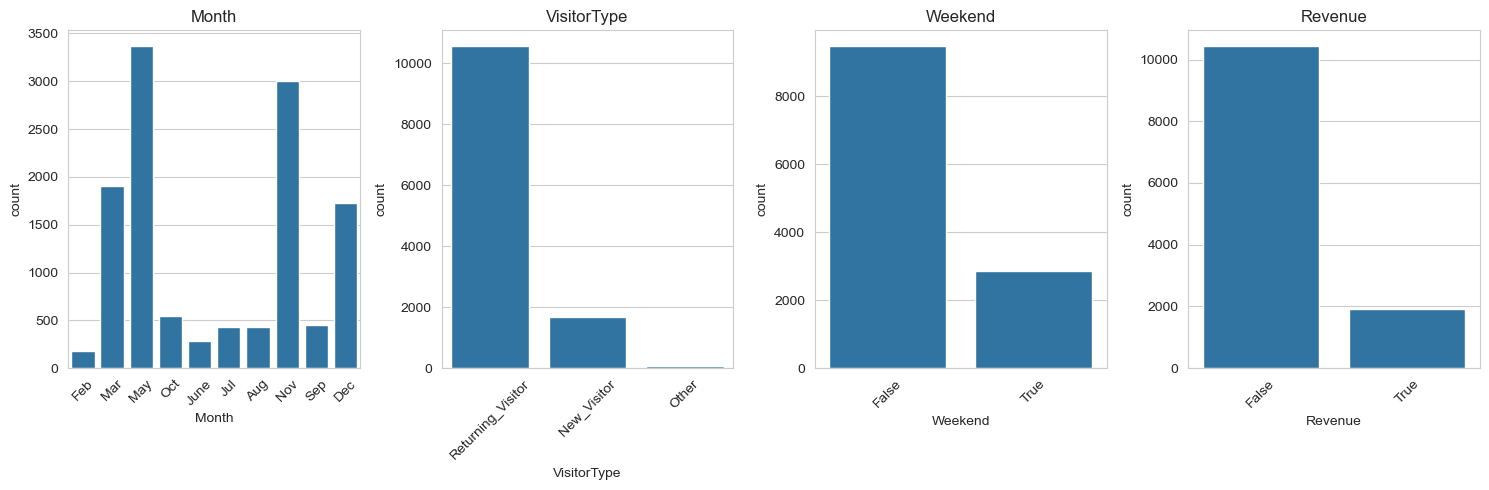

In [17]:
# Como não existem valores faltantes na base de dados, podemos realizar as analises

# Estilo dos gráficos
sns.set_style("whitegrid")

# Para utilizar o gráfico de histograma, é necessário selecionar as variaveis numericas
var_numericas = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration',
                'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues']

plt.figure(figsize=(15, 10))
for i, var in enumerate(var_numericas, start=1):
    plt.subplot(3, 3, i)
    sns.histplot(df[var], kde=True)
    plt.title(var)
plt.tight_layout()
plt.show()

# Analisar as proporções das variáveis categóricas por meio de gráficos de barras
plt.figure(figsize=(15, 5))
categorical_vars = ['Month', 'VisitorType', 'Weekend', 'Revenue']
for i, var in enumerate(categorical_vars, start=1):
    plt.subplot(1, 4, i)
    sns.countplot(data=df, x=var)
    plt.title(var)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Variáveis de agrupamento

Liste as variáveis que você vai querer utilizar. Essa é uma atividade importante do projeto, e tipicamente não a recebemos pronta. Não há resposta pronta ou correta, mas apenas critérios e a sua decisão. Os critérios são os seguintes:

- Selecione para o agrupamento variáveis que descrevam o padrão de navegação na sessão.
- Selecione variáveis que indiquem a característica da data.
- Não se esqueça de que você vai precisar realizar um tratamento especial para variáveis qualitativas.
- Trate adequadamente valores faltantes.

In [18]:
# Selecionando as variaveis do comportamento de navegação
# Como a variavel Weekend é uma variável categórica, é necessário transformar em dummies

var_util = ['Administrative', 'Administrative_Duration', 'Informational', 
            'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
            'SpecialDay', 'Weekend']

df_var = df[var_util].copy()

df_var_dummie = pd.get_dummies(df_var, columns=['Weekend'])

df_var_dummie.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,SpecialDay,Weekend_False,Weekend_True
0,0,0.0,0,0.0,1,0.000000,0.0,True,False
1,0,0.0,0,0.0,2,64.000000,0.0,True,False
2,0,0.0,0,0.0,1,0.000000,0.0,True,False
3,0,0.0,0,0.0,2,2.666667,0.0,True,False
4,0,0.0,0,0.0,10,627.500000,0.0,False,True


## Número de grupos

Nesta atividade vamos adotar uma abordagem bem pragmática e avaliar agrupamentos hierárquicos com 3 e 4 grupos, por estarem bem alinhados com uma expectativa e estratégia do diretor da empresa. 

*Atenção*: Cuidado se quiser fazer o dendrograma, pois com muitas observações ele pode ser mais complicado de fazer, e dependendo de como for o comando, ele pode travar o *kernell* do seu python.

In [19]:
# Padronizando os dados
padronizador = StandardScaler()
df_var_dummie_pad = padronizador.fit_transform(df_var_dummie)

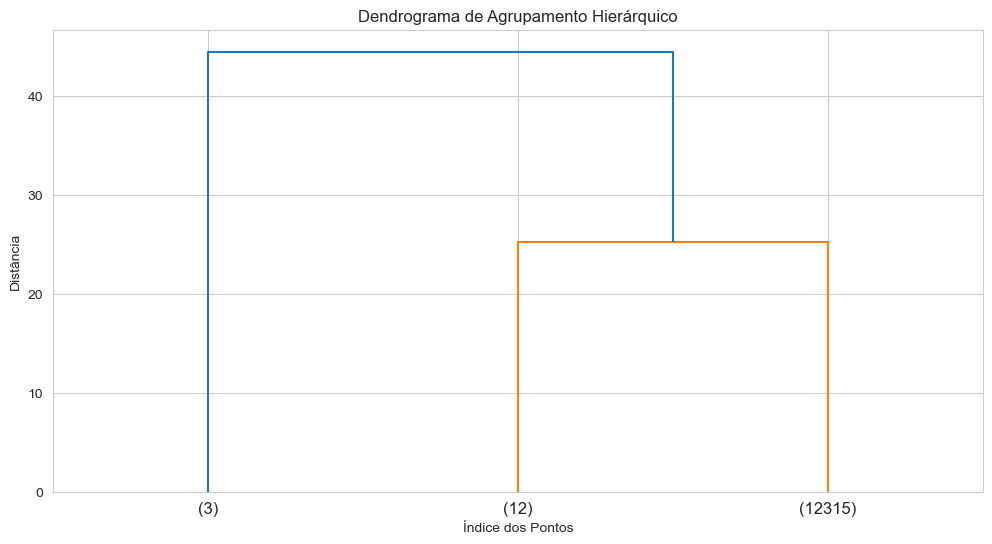

In [20]:
# Criando os agrupamentos hierarquicos com 3 grupos
agrup_3 = AgglomerativeClustering(linkage="complete", distance_threshold=None, n_clusters=3)
labels_3 = agrup_3.fit_predict(df_var_dummie_pad)

# Fazer o Dendrograma
plt.figure(figsize=(12, 6))
plt.title('Dendrograma de Agrupamento Hierárquico')
plt.xlabel('Índice dos Pontos')
plt.ylabel('Distância')
Z = linkage(df_var_dummie_pad, 'complete')
dendrogram(Z, p=3, truncate_mode='lastp', show_leaf_counts=True)
plt.show()

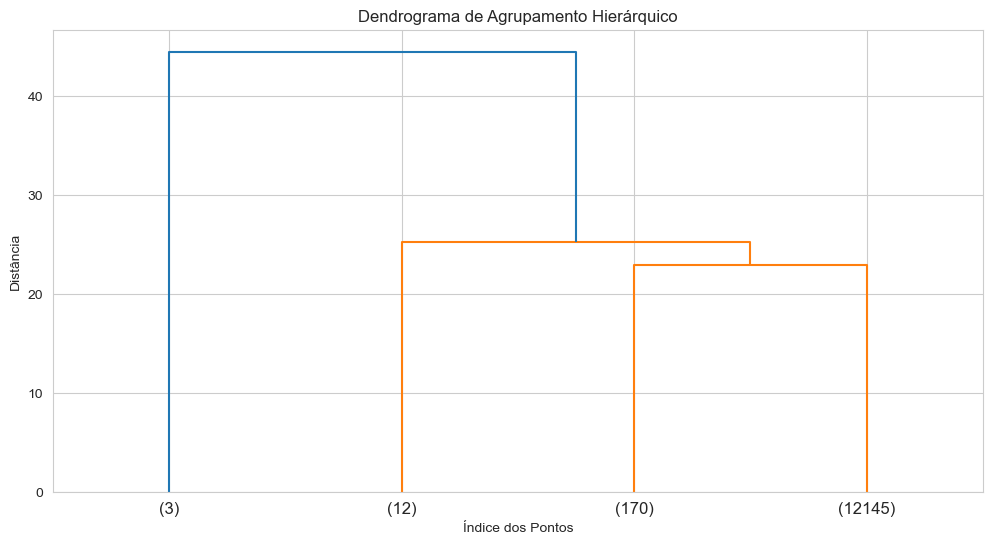

In [21]:
# Criando os agrupamentos hierarquicos com 4 grupos
agrup_4 = AgglomerativeClustering(linkage="complete", distance_threshold=None, n_clusters=4)
labels_4 = agrup_4.fit_predict(df_var_dummie_pad)

# Fazer o Dendrograma
plt.figure(figsize=(12, 6))
plt.title('Dendrograma de Agrupamento Hierárquico')
plt.xlabel('Índice dos Pontos')
plt.ylabel('Distância')
Z = linkage(df_var_dummie_pad, 'complete')
dendrogram(Z, p=4, truncate_mode='lastp', show_leaf_counts=True)
plt.show()

## Avaliação dos grupos

Construa os agrupamentos com a técnica adequada que vimos em aula. Não se esqueça de tratar variáveis qualitativas, padronizar escalas das quantitativas, tratar valores faltantes e utilizar a distância correta.

Faça uma análise descritiva para pelo menos duas soluções de agrupamentos (duas quantidades diferentes de grupos) sugeridas no item anterior, utilizando as variáveis que estão no escopo do agrupamento.
- Com base nesta análise e nas análises anteriores, decida pelo agrupamento final. 
- Se puder, sugira nomes para os grupos.

Com base nos agrupamentos analisados, a melhor solução aparenta ser a com 4 grupos. Pois demostra uma melhor interpretação do grupo que entra na página e após algum tempo realiza a compra, que é o grupo a qual estão inseridos os valores de indice 3, 12 e 170.

## Avaliação de resultados

Avalie os grupos obtidos com relação às variáveis fora do escopo da análise (minimamente *bounce rate* e *revenue*). 
- Qual grupo possui clientes mais propensos à compra?

In [22]:
# Adicionar os rótulos de agrupamento ao DataFrame original
df['Grupo'] = labels_4

# Calcular a média de BounceRates e a proporção de Revenue para cada grupo
analise_grupo = df.groupby('Grupo').agg({'BounceRates': 'mean', 'Revenue': 'mean'})

# Análises dos grupos
print("Análise do Grupo:")
print(analise_grupo)

Análise do Grupo:
       BounceRates   Revenue
Grupo                       
0         0.003644  0.000000
1         0.022416  0.153561
2         0.006412  0.416667
3         0.007576  0.223529
